In [1]:
from transformers import pipeline, set_seed
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from accelerate.utils import release_memory
import torch
from datasets import Dataset
from huggingface_hub import login
from IPython.display import display, Markdown

import pandas as pd
import kagglehub
from kaggle_secrets import UserSecretsClient

import gc
import warnings
import random
import numpy as np

warnings.filterwarnings('ignore')


# Ensuring consistent results by fixing the seed for all random number generators
set_seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

writeups = pd.read_csv('/kaggle/input/kaggle-winning-solutions-methods/kaggle_winning_solutions_methods.csv')
writeups = writeups.drop_duplicates(subset=['link', 'writeup']).reset_index(drop=True)

# hf_access_token = UserSecretsClient().get_secret("hf_mytoken")
# login(token = hf_access_token)

model = "/kaggle/input/gemma/transformers/2b-it/3"

pipe = pipeline(
    "text-generation",
    model=model,
    model_kwargs={"torch_dtype": torch.float16},
    device='cuda',
    max_new_tokens=512
)

2025-05-25 14:40:52.497778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748184052.977568      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748184053.109823      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


In [2]:
# first writeup
writeup = writeups.iloc[0,9]
print(f'number of characters:{len(writeup)}')

number of characters:9864


In [3]:
# simulation of chat
messages = [
    {
        "role": "user",
        "content": "Summarize the following text in a technical way. Focus on facts, numbers and strategies used. Divide the summary in chapters, be impersonal and use bullet points:\n\n{}".format(writeup)
    }
]

In [4]:
# most of LLMs use is in CHAT format -> the model recieves a messsage and tries to answer
prompt = pipe.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

# generate an output based on prompt using defined pipe:
outputs = pipe(
    prompt,
    do_sample=True,
    temperature=0.1,
    top_k=20,
    top_p=0.3,
    add_special_tokens=True   
)

# cutting the beggining (firtst len(prompt) characters -> we want to see just summary)
display(Markdown(outputs[0]['generated_text'][len(prompt):].replace('#', '')))

**Chapter 1: Introduction**

* Overview of the project: using an EfficientNet-B0 model for lip and pose classification.
* Data preparation:
    * 18 lip points, 20 pose points, and all hand points were extracted.
    * Various augmentations and transformer pre-processing were applied.
    * The input size was 160x80x3.

**Chapter 2: Data Preprocessing**

* CNN pre-processing:
    * Global affine, shift-scale-rotate, and flip pose were applied.
    * Mixup augmentation was used for CNNs.
* Transformer pre-processing:
    * Only 61 points were kept, including 40 lip points and 21 hand points.
    * Randomly selected distances and angles were included.

**Chapter 3: Training**

* CNN training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Weighted cross-entropy loss with class weights.
    * EfficientNet-B0 with 5 blocks and 256 hidden units.
* Transformer training:
    * One-fold cross-validation with a random split and 0.1 warm-up.
    * Ranger optimizer with 60% flat and 40% cosine annealing learning rate schedule.
    * 4-layer, 256 hidden-size, 512 intermediate-size transformer.

**Chapter 4: Hyperparameter Tuning**

* Optuna was used to tune most parameters.
* The parameters list for CNN and transformer training are provided.

**Chapter 5: Submissions and Ensemble**

* EfficientNet-B0 achieved a leaderboard score of approximately 0.8.
* Ensemble of EfficientNet-B0, BERT, and DeBERTa was created.
* A key feature was using the ensemble without softmax, which provided a boost of around 0.01.

**Chapter 6: Conclusion**

* The project achieved a high accuracy on the lip and pose classification task.
* The EfficientNet-B0 model with ensemble achieved the best performance.
* The conversion of DepthwiseConv2D operation was a challenge, but a faster version was developed.

## Prompt engineering
- depending on the audience, the prompt can vary -> we want it to be more aligned with user's needs
- example:

In [5]:
messages_eli5 = [
    {
        "role":"user",
        "content": "Summarize the following text as if I am 5 year old: {}".format(writeup)
    }
]

prompt_eli5 = pipe.tokenizer.apply_chat_template(messages_eli5, tokenize=False, add_generation_prompt=True)
output_eli5 = pipe(
    prompt_eli5,
    add_special_tokens=True,
    top_p=0.3,
    top_k=20,
    temperature=0.1,
    do_sample=True
)

display(Markdown(output_eli5[0]["generated_text"][len(prompt_eli5):].replace('#', '')))

Sure, here's a summary of the text:

**Data Preprocessing:**

* Extract 80 points from the image, including lip and body points.
* Apply various augmentations and normalizations.
* Use a specific interpolation method to handle the time axis.

**Training:**

* Use EfficientNet-B0 for CNN training and transformers for the transformer.
* Train on one fold with a random split and use weighted cross-entropy loss.
* Tune hyperparameters with Optuna.

**Ensemble:**

* Combine multiple models in a single TensorFlow module.
* Calculate ensemble weights based on fold 0 scores.
* Apply the ensemble to the full dataset.

**Results:**

* EfficientNet-B0 achieved a leaderboard score of 0.8.
* Transformers improved the score to 0.81.
* Ensemble included EfficientNet-B0, BERT, and DeBERTa.

**Key Takeaways:**

* Depthwise convolution performed well for these tasks.
* EfficientNet-B0 is a highly efficient model.
* Ensemble can improve performance.

- #### There is also a technique called **"Few shot prompting"**, where we provide examples that show the model how it should work:

In [6]:
messages_few_shot = [
    {
        "role": "user",
        "content": "This film was great, rich of details and with great actors."},
    {
        "role": "assistant",
        "content": "SENTIMENT: Positive. \n SUBJECT: Film "},
    {
        "role": "user",
        "content": "The park is dirty, I don't like it."},
    {
        "role": "assistant",
        "content": "SENTIMENT: Negative. \n SUBJECT: Park"},
    {
        "role": "user",
        "content": "This song is perfect."}
]

prompt_few_shot = pipe.tokenizer.apply_chat_template(messages_few_shot, tokenize=False, add_generation_prompt=True)
outputs_few_shot = pipe(
    prompt_few_shot,
    top_p=0.3,
    top_k=20,
    temperature=0.1,
    add_special_tokens=True,
    do_sample=True
)

display(Markdown(outputs_few_shot[0]["generated_text"][len(prompt_few_shot):]))

SENTIMENT: Positive. 
 SUBJECT: Song
The lyrics are beautiful and the music is catchy.

-> the model learned how to perform the task with JUST 2 examples using the apply_chat_template!!!

#### Pipeline parameters:
- **top_k**: the top k most likely tokens are kept, and the next token is sampled from them

  
- **top_p**: the minimal set of tokens whose cumulative probability exceeds p. Sampling is done from this set (also known as nucleus sampling)

- **temperature**: controls how random or confident the model is; lower values make the model more confident and deterministic, while higher values increase randomness and creativity
  
- **do_sample**: boolean; false->always picks the most probable next token (greedy decoding); true-> samples the next token based on probabilities (typically used with top_k, top_p, or temperature)

## Text summarization - methods + strategies

- we are focusing on 3 strategies:
  1. Stuffing
  2. MapReduce
  3. Refine

1. STUFFING
   - what we've done so far: we pass the ENTIRE DATA to the LLM by stuffing it into the prompt as context
   - Pros: single call to the LLM, comprehensive context
   - Cons: limited data size, bad quality for large documents
     
  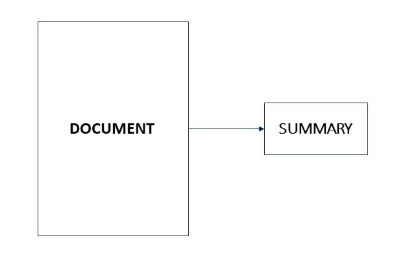


2. MAP REDUCE
   - multi-stage summarization
   - first we split document into chunks, than summarize each chunk, and finally combine those summaries into one
   - Pros: no limit for document size, each chunk can be processed in parallel (higher speed!)
   - Cons: multiple LLMs required; potential loss of information, because chunks are seen without context
     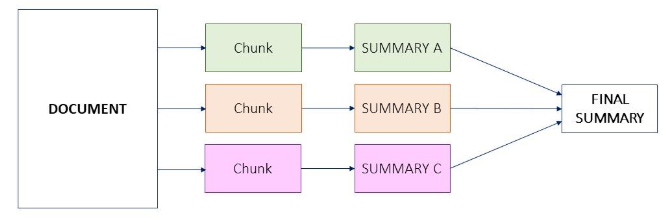

3. REFINE
   - multi-stage summarization; **ITTERATIVE APROACH**
   - first we split document into chunks, then the first chunk is summarized; afterwards, for each following chunk, the previous output is combined with new information(chunk) and then the LLM is used to improve(refine) previous summary
   - Pros: no limit for document size, MapReduce's problem of potential info loss is solved 
   - Cons: multiple LLMs required; LLM errors and hallucinations can propagade during each iteration affecting the quality of final output
     
   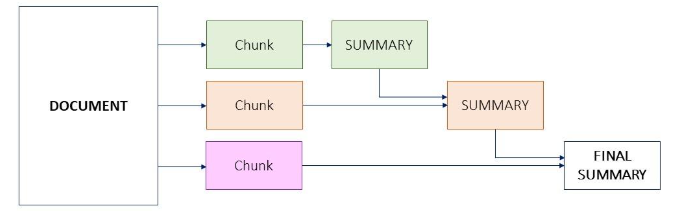

#### Document splitting strategies